In [1]:
!pip install Sastrawi
!pip install vaderSentiment
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [3]:

# Memuat dataset hasil clustering
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/youtube-mulyono.csv')

# Menampilkan beberapa baris awal dari dataset
print(data.head())

Mounted at /content/drive
            publishedAt             authorDisplayName  \
0  2025-02-11T11:33:50Z                  @NajwaShihab   
1  2025-02-11T12:32:17Z  @ramdanachmadyusufmaulana412   
2  2025-02-11T12:33:10Z              @RijalulHadi-h9z   
3  2025-02-11T12:38:23Z              @RijalulHadi-h9z   
4  2025-02-11T12:38:26Z            @kentanggoreng5510   

                                         textDisplay  likeCount  
0  Tonton juga [EKSKLUSIF] Mata Najwa eps. Jokowi...       1534  
1  Saya SANGAT MENGHORMTI bapak prof quraisy shih...        237  
2  Gibran ngak berani keluar dari daerah jawa,,,J...         79  
3  IKN harus lanjut pak presiden prabowo datang  ...         79  
4  Tumben berani <br>Tapi ....da yg g biasa <br> ...         44  


# 1. Prepocessing data
(Nanti kode akan saya comment, soalnya prosesnya bisa sampe 1 jam)


In [6]:
# Baca CSV dan buat dictionary EMOTICON
emoji_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/emoticon_data.csv')
emoji_dict = dict(zip(emoji_df['Emoji'], emoji_df['Unicode name']))

In [8]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Inisialisasi stopwords
stop_words_nltk = set(stopwords.words('indonesian'))
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def replace_emoji_with_words(comment, emoji_dict):
    for emoji, word in emoji_dict.items():
        comment = comment.replace(emoji, f" {word} ")
    return comment


def preprocess_comments(comments):
    cleaned_comments = []

    for comment in comments:
        # Case Folding
        comment = comment.lower()

        # Replace Emoji with words
        comment = replace_emoji_with_words(comment, emoji_dict)

        # Removal Special Characters
        comment = re.sub(r'http\S+|www\S+|https\S+', '', comment)  # Remove URLs
        comment = re.sub(r'@\w+|#', '', comment)  # Remove mentions and hashtags
        comment = re.sub(r'[^a-zA-Z0-9\s]', '', comment)  # Remove special characters
        comment = re.sub(r'\d+', '', comment)  # Remove numbers

        # Remove extra whitespace
        comment = re.sub(r'\s+', ' ', comment).strip()  # Remove extra spaces and strip

        # Stopword Removal
        tokens = comment.split()  # Tokenization
        filtered_tokens = [word for word in tokens if word not in stop_words_nltk]

        # Stemming
        stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

        # Join tokens back into a single string
        cleaned_comments.append(' '.join(stemmed_tokens))

    return cleaned_comments

# Apply the preprocessing function to the 'textDisplay' column
data['cleaned_comments'] = preprocess_comments(data['textDisplay'])

# Menghapus baris yang memiliki nilai kosong di kolom 'cleaned_comments'
data = data.dropna(subset=['cleaned_comments'])

# Optionally, save the processed data to a new CSV file
data.to_csv('processed_youtube_comments.csv', index=False)

# Display the first few rows of the processed data
print(data[['textDisplay', 'cleaned_comments']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                         textDisplay  \
0  Tonton juga [EKSKLUSIF] Mata Najwa eps. Jokowi...   
1  Saya SANGAT MENGHORMTI bapak prof quraisy shih...   
2  Gibran ngak berani keluar dari daerah jawa,,,J...   
3  IKN harus lanjut pak presiden prabowo datang  ...   
4  Tumben berani <br>Tapi ....da yg g biasa <br> ...   

                                    cleaned_comments  
0  tonton eksklusif mata najwa eps jokowi ikn gib...  
1  menghormti prof quraisy shihab moga mba nana a...  
2  gibran ngak berani daerah jawajakarta udah nga...  
3  ikn presiden prabowo ikn nusantara quotquotquo...  
4  tumben berani brtapi da yg g br mata najwa dur...  


# 2. Prepocessing Data


In [9]:
data = pd.read_csv('/content/processed_youtube_comments.csv')
# Display the first few rows of the processed data
print(data[['textDisplay', 'cleaned_comments']].head())

                                         textDisplay  \
0  Tonton juga [EKSKLUSIF] Mata Najwa eps. Jokowi...   
1  Saya SANGAT MENGHORMTI bapak prof quraisy shih...   
2  Gibran ngak berani keluar dari daerah jawa,,,J...   
3  IKN harus lanjut pak presiden prabowo datang  ...   
4  Tumben berani <br>Tapi ....da yg g biasa <br> ...   

                                    cleaned_comments  
0  tonton eksklusif mata najwa eps jokowi ikn gib...  
1  menghormti prof quraisy shihab moga mba nana a...  
2  gibran ngak berani daerah jawajakarta udah nga...  
3  ikn presiden prabowo ikn nusantara quotquotquo...  
4  tumben berani brtapi da yg g br mata najwa dur...  


In [10]:
# Inisialisasi SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Fungsi untuk menganalisis sentimen
def analyze_sentiment(comment):
    # Check if the comment is a string
    if isinstance(comment, str):
        sentiment_scores = analyzer.polarity_scores(comment)
        return sentiment_scores
    else:
        # Handle non-string comments (e.g., return default sentiment or skip)
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}  # Example: return neutral sentiment

# Terapkan analisis sentimen ke kolom 'cleaned_comments'
data['sentiment_scores'] = data['cleaned_comments'].apply(analyze_sentiment)

# Pisahkan skor sentimen menjadi kolom terpisah
data['neg'] = data['sentiment_scores'].apply(lambda x: x['neg'])
data['neu'] = data['sentiment_scores'].apply(lambda x: x['neu'])
data['pos'] = data['sentiment_scores'].apply(lambda x: x['pos'])
data['compound'] = data['sentiment_scores'].apply(lambda x: x['compound'])

# Menampilkan beberapa baris untuk memastikan
print(data[['cleaned_comments', 'neg', 'neu', 'pos', 'compound']].head())

                                    cleaned_comments  neg  neu  pos  compound
0  tonton eksklusif mata najwa eps jokowi ikn gib...  0.0  1.0  0.0       0.0
1  menghormti prof quraisy shihab moga mba nana a...  0.0  1.0  0.0       0.0
2  gibran ngak berani daerah jawajakarta udah nga...  0.0  1.0  0.0       0.0
3  ikn presiden prabowo ikn nusantara quotquotquo...  0.0  1.0  0.0       0.0
4  tumben berani brtapi da yg g br mata najwa dur...  0.0  1.0  0.0       0.0


Akurasi: 92.22%


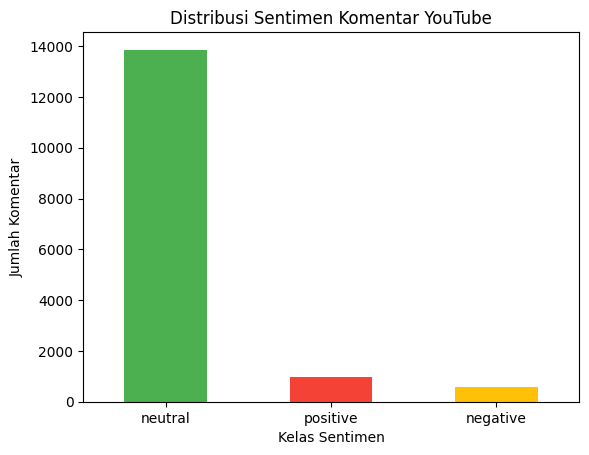

In [11]:
# Terapkan analisis sentimen
# data['sentiment'] = data['cleaned_comments'].apply(analyze_sentiment) # Original line - This line assign dictionary to 'sentiment' column

# Get sentiment label based on compound score
data['sentiment'] = data['compound'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

# Fungsi untuk melatih model
def train_model(comments, labels):
    # Drop rows with missing values in 'comments' or 'labels'
    df = pd.DataFrame({'comments': comments, 'labels': labels})
    df = df.dropna()  # Drop rows with NaN values in either column
    comments = df['comments']
    labels = df['labels']

    X_train, X_test, y_train, y_test = train_test_split(comments, labels, test_size=0.2, random_state=42)

    # Menggunakan TF-IDF untuk ekstraksi fitur
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    model = MultinomialNB()
    model.fit(X_train_tfidf, y_train)

    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Akurasi: {accuracy * 100:.2f}%')

    return model, vectorizer

# Melatih model
model, vectorizer = train_model(data['cleaned_comments'], data['sentiment'])

# Fungsi untuk memvisualisasikan distribusi sentimen
def plot_sentiment_distribution(labels):
    label_counts = pd.Series(labels).value_counts()
    label_counts.plot(kind='bar', color=['#4CAF50', '#F44336', '#FFC107'])
    plt.title('Distribusi Sentimen Komentar YouTube')
    plt.xlabel('Kelas Sentimen')
    plt.ylabel('Jumlah Komentar')
    plt.xticks(rotation=0)
    plt.show()

# Visualisasi distribusi sentimen
plot_sentiment_distribution(data['sentiment'])

In [13]:
 pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.28.0.37.27
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.1
bokeh==3.7.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
commun